<a href="https://colab.research.google.com/github/RachelRamirez/misclassification_matrix/blob/main/PA_Shfl_w%5B9%2C4%5D_1000_40D_Misclassification_Cost_Matrix_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## What happens when I use PA method with Weighted_Matrix with w_array[9, 4] = 10 and Model Shuffle=True and I reduce the capacity of the neural network from 512 to 40 connections

  Filename "PA_Shfl_w[9,4]_2.0_40D_Misclassification_Cost_Matrix_Example"

Its hard to see if the misclassification weight is making a difference so I am now making the neural network not as great by reducing the number of dense connections in each layer from 512 to X/40.  Realized after I saved that everything was taking 15 epochs so I need to increase training time - turns out it only needed 16

I'm changing Model Shuffle=True to see if that helps with the validation loss jumping around

The results of running the  ISantaro appeared counterintuitive, because when I increased the cost of a misclassification, more misclassifications were made. It was hard to see at first because it wasn't consistently happening, it happened 7 out of 30 times, but when it happened it was a very large number of misclassifications.   So now I'm looking to compare another code implementation,  by Phil Alton here:  https://stackoverflow.com/a/61963004 

Remember to change the [Admin File stuff]  below and the Weight Matrix before Running

#### Check timezone if incorrect restart

In [2]:
# How to change the local time in Google Colab
!rm /etc/localtime
!ln -s /usr/share/zoneinfo/US/Eastern /etc/localtime
!date

#If this doesn't show the local time correctly, then you need to restart.
import time
time.localtime(time.time())

Tue 28 Feb 2023 10:43:55 AM EST


time.struct_time(tm_year=2023, tm_mon=2, tm_mday=28, tm_hour=15, tm_min=43, tm_sec=55, tm_wday=1, tm_yday=59, tm_isdst=0)

### Reproducible Seeds

In [3]:
#For Reproducibility
import numpy as np
# np.random.seed(1337)  # for reproducibility

import tensorflow as tf
# tf.random.set_seed(33)

import random as python_random
# python_random.seed(4)

# https://www.tensorflow.org/api_docs/python/tf/keras/utils/set_random_seed
tf.keras.utils.set_random_seed(342) #Possibly use next iteration if the above doesn't work


# Running more than once causes variation.  try adding this:
# Set seed value
seed_value = 56
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

print("TF version: " , tf.__version__ )
print("Keras version: " , tf.keras.__version__ )

TF version:  2.11.0
Keras version:  2.11.0


### Import rest of Library

In [4]:

# from https://github.com/keras-team/keras/issues/2115#issuecomment-204060456
# witha correction on the weighted function in the middle 

'''Train a simple deep NN on the MNIST dataset.
Get to 98.40% test accuracy after 20 epochs
(there is *a lot* of margin for parameter tuning).
2 seconds per epoch on a K520 GPU.
'''

from __future__ import print_function  #do i still need this?
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
import keras.backend as K
from itertools import product
import functools
from functools import partial
from time import ctime
from time import sleep
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from sklearn.metrics import confusion_matrix

## MORE REPEATABILITY STUFF NEEDED - If theres a way to update this to V2 of Tensorflow great, otherwise I had to use TF 1.0 code
# 5. Configure a new global `tensorflow` session (https://stackoverflow.com/questions/50659482/why-cant-i-get-reproducible-results-in-keras-even-though-i-set-the-random-seeds)
# from keras import backend as K


#I believe thecode below is to help things be repeatable each time different sections in my google colab notebook execute
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

### Define batch, epochs, and format data

In [5]:
batch_size = 256 # I originally had it very  high batch size to reduce the variation in the data each batch and hope it makes the model training more nearly identical which it did, then i bring it back down to something reasonable to get better results training the NN
nb_classes = 10
nb_epoch = 45

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()


X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)


11490434/11490434 [==============================] - 0s 0us/step
60000 train samples
10000 test samples


### Define Same Model but use normal Categorical CrossEntropy with no extra cost-matrix of Weights

In [6]:
# def normal_method():

#   model = Sequential()
#   model.add(Dense(512, input_shape=(784,) ,kernel_initializer=tf.keras.initializers.glorot_uniform(seed=42)))
#   model.add(Activation('relu'))
#   model.add(Dropout(0.2))
#   model.add(Dense(512, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=42)))
#   model.add(Activation('relu'))
#   model.add(Dropout(0.2))
#   model.add(Dense(10, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=42)))
#   model.add(Activation('softmax'))

#   rms = RMSprop()
#   # model.compile(loss=ncce, optimizer=rms)
#   model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=rms, metrics='categorical_accuracy', )

#   #add early_stop to prevent overfittings
#   # callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

#   model_history = model.fit(X_train, Y_train,
#             batch_size=batch_size, epochs=nb_epoch, verbose=2,
#             validation_data=(X_test, Y_test),shuffle=False, use_multiprocessing=True
#             , callbacks = [callback])

  
#   # model.evaluate(X_test, Y_test, verbose=1)  # I know this isn't the typical use of train/val/test sets, please dont' comment on that
  
#   #Predict
#   y_prediction = model.predict(X_test)
#   y_prediction  = np.argmax(y_prediction, axis=1)
#   # Y_prediction = np_utils.to_categorical(y_prediction, nb_classes) #If I want to do SparseCategoricalAccuracy

#   #Create confusion matrix and normalizes it over predicted (columns)
#   # result = confusion_matrix(y_test, y_prediction , normalize='pred')  #if I want percentages instead of raw counts

  
#   cm = confusion_matrix(y_test, y_prediction)
#   cm = pd.DataFrame(cm, range(10),range(10))

#   #This shows a pretty confusion matrix which I don't neeed to show right now
#   # plt.figure(figsize = (10,10))
#   # sns.heatmap(cm, annot=True, annot_kws={"size": 12}) # font size
#   # plt.show()
#   # cm_normal = cm

#   return cm


### Weighted Categorical Cross Entropy Class

In [7]:
class WeightedCategoricalCrossentropy(tf.keras.losses.CategoricalCrossentropy):

  def __init__(self, cost_mat, name='weighted_categorical_crossentropy', **kwargs):

    cost_mat = np.array(cost_mat)   
    ## when loading from config, self.cost_mat returns as a list, rather than an numpy array. 
    ## Adding the above line fixes this issue, enabling .ndim to call sucessfully. 
    ## However, this is probably not the best implementation
    assert(cost_mat.ndim == 2)
    assert(cost_mat.shape[0] == cost_mat.shape[1])
    super().__init__(name=name, **kwargs)
    self.cost_mat = K.cast_to_floatx(cost_mat)

  def __call__(self, y_true, y_pred, sample_weight=None):
    assert sample_weight is None, "should only be derived from the cost matrix"  
    return super().__call__(
        y_true=y_true, 
        y_pred=y_pred, 
        sample_weight=get_sample_weights(y_true, y_pred, self.cost_mat),
    )


  def get_config(self):
    config = super().get_config().copy()
    # Calling .update on the line above, during assignment, causes an error with config becoming None-type.
    config.update({'cost_mat': (self.cost_mat)})
    return config

  @classmethod
  def from_config(cls, config):
    # something goes wrong here and changes self.cost_mat to a list variable.
    # See above for temporary fix
    return cls(**config)

def get_sample_weights(y_true, y_pred, cost_m):
    num_classes = len(cost_m)

    y_pred.shape.assert_has_rank(2)
    assert(y_pred.shape[1] == num_classes)
    y_pred.shape.assert_is_compatible_with(y_true.shape)

    y_pred = K.one_hot(K.argmax(y_pred), num_classes)

    y_true_nk1 = K.expand_dims(y_true, 2)
    y_pred_n1k = K.expand_dims(y_pred, 1)
    cost_m_1kk = K.expand_dims(cost_m, 0)

    sample_weights_nkk = cost_m_1kk * y_true_nk1 * y_pred_n1k
    sample_weights_n = K.sum(sample_weights_nkk, axis=[1, 2])

    return sample_weights_n


# Register the loss in the Keras namespace to enable loading of the custom object.
tf.keras.losses.WeightedCategoricalCrossentropy = WeightedCategoricalCrossentropy
 

### WeightedCategoricalCross Entropy Function 

In [8]:
def PA_method(cost_matrix):

  model3 = Sequential()
  model3.add(Dense(40, input_shape=(784,), kernel_initializer=tf.keras.initializers.glorot_uniform(seed=42)))
  model3.add(Activation('relu'))
  model3.add(Dropout(0.2))
  model3.add(Dense(40, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=42)))
  model3.add(Activation('relu'))
  model3.add(Dropout(0.2))
  model3.add(Dense(10,kernel_initializer=tf.keras.initializers.glorot_uniform(seed=42)))
  model3.add(Activation('softmax'))

  rms = RMSprop()  #https://keras.io/api/optimizers/rmsprop/

  model3.compile(loss=WeightedCategoricalCrossentropy(cost_matrix), optimizer=rms,  metrics='categorical_accuracy',)
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights = True)

  model3_history = model3.fit(X_train, Y_train,
            batch_size=batch_size, epochs=nb_epoch, verbose=2,
            validation_data=(X_test, Y_test), shuffle=True, use_multiprocessing=True
            ,callbacks = [callback]
            )

 

  #Predict
  y_prediction = model3.predict(X_test)
  y_prediction  = np.argmax(y_prediction, axis=1)
  # Y_prediction = np_utils.to_categorical(y_prediction, nb_classes)

  #Create confusion matrix and normalizes it over predicted (columns)
  # result = confusion_matrix(y_test, y_prediction , normalize='pred')

  

  cm3 = confusion_matrix(y_test, y_prediction)
  cm3 = pd.DataFrame(cm3, range(10),range(10))
  # plt.figure(figsize = (10,10))
  # cm3
  # sns.heatmap(cm2, annot=True, annot_kws={"size": 12}) # font size
  # plt.show()

  # cm_using_weighted_new = cm3

  print(model3_history.history)
 
  plt.plot(model3_history.history['categorical_accuracy'])
  plt.plot(model3_history.history['val_categorical_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  

  plt.plot(model3_history.history['loss'])
  plt.plot(model3_history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()




  return cm3, model3_history

### *Keep Track of Experimental Admin Stuff - #Runs and #CostMatrix

> Change the cost matrix and number of runs and check the file extension name 


#### *Define Cost Matrix and Method

In [9]:
# Experimental Admin Stuff
cost_matrix = np.ones((10,10))

### Weight of Misclassification
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cost_matrix[9, 4] = 1000
cost_str = str(cost_matrix[9, 4])
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



### File Extension to reference in JMP : weights_method_cost
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
file_extension = "w[9,4]_PA_" + cost_str + "_Shfl_40D_"
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


np.set_printoptions(suppress=True)
np.set_printoptions(precision=2)

print("Last run using ", cost_str)

Last run using  1000.0


#### Run Experiments

1
Epoch 1/45
235/235 - 13s - loss: 2.3161 - categorical_accuracy: 0.6047 - val_loss: 0.5747 - val_categorical_accuracy: 0.7979 - 13s/epoch - 54ms/step
Epoch 2/45
235/235 - 2s - loss: 1.2011 - categorical_accuracy: 0.7688 - val_loss: 0.4085 - val_categorical_accuracy: 0.8355 - 2s/epoch - 7ms/step
Epoch 3/45
235/235 - 2s - loss: 1.0507 - categorical_accuracy: 0.8167 - val_loss: 0.3387 - val_categorical_accuracy: 0.8647 - 2s/epoch - 7ms/step
Epoch 4/45
235/235 - 2s - loss: 0.9595 - categorical_accuracy: 0.8412 - val_loss: 0.3308 - val_categorical_accuracy: 0.8652 - 2s/epoch - 7ms/step
Epoch 5/45
235/235 - 2s - loss: 0.7898 - categorical_accuracy: 0.8557 - val_loss: 0.2878 - val_categorical_accuracy: 0.8857 - 2s/epoch - 6ms/step
Epoch 6/45
235/235 - 2s - loss: 0.8157 - categorical_accuracy: 0.8659 - val_loss: 0.2695 - val_categorical_accuracy: 0.8918 - 2s/epoch - 7ms/step
Epoch 7/45
235/235 - 1s - loss: 0.8251 - categorical_accuracy: 0.8633 - val_loss: 0.2791 - val_categorical_accuracy: 0.

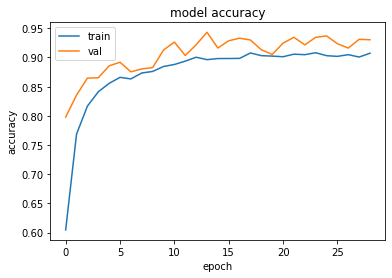

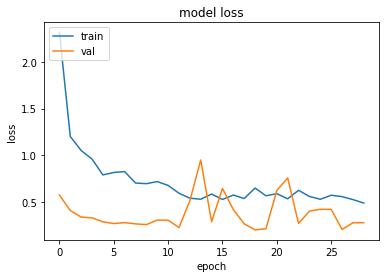

CM: 
      0     1    2    3    4    5    6    7    8    9
0  959     1    2    1    0    3    9    2    3    0
1    0  1118    4    3    0    1    3    1    5    0
2    7     3  986    4    2    1    5   11   12    1
3    0     2   15  963    0   12    0   11    5    2
4    0     1    5    0  454    0    9    1    3  509
5    4     1    0    9    1  847   11    4    8    7
6    7     4    1    1    3    6  933    0    2    1
7    3    14   16    5    0    0    0  979    1   10
8    7     4    5    9    2    8    5    4  923    7
9    2     8    0   12    0    8    1    6    2  970


In [10]:
#@title
cm = np.zeros([10,10])
combined_cms = np.empty((1,100))

combined_history_dictionary = {}  #because there will be a unknown number of epochs a dictionary is probly a better fit
combined_history_list       = []


## Define the total number of runs
### ~~~~~~~~~
runs = 1
### ~~~~~~~~~~

for i in range(1,runs+1):
  print(i)
  cm2 , history =  PA_method(cost_matrix)    #Individual CM, and Training/Validation History
  print("CM: \n", cm2)
  

  combined_history_dictionary[i] = history
  combined_history_list.append(history)
  # cm += cm2                   #Aggregating for an Average
  cm2_array = np.asarray(cm2)  #Indiv CM as array for storing
  combined_cms = np.vstack((combined_cms,cm2_array.reshape((1,100))))



# cm_new = cm/30

In [11]:
# dir(history)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_chief_worker_only',
 '_implements_predict_batch_hooks',
 '_implements_test_batch_hooks',
 '_implements_train_batch_hooks',
 '_keras_api_names',
 '_keras_api_names_v1',
 '_supports_tf_logs',
 'epoch',
 'history',
 'model',
 'on_batch_begin',
 'on_batch_end',
 'on_epoch_begin',
 'on_epoch_end',
 'on_predict_batch_begin',
 'on_predict_batch_end',
 'on_predict_begin',
 'on_predict_end',
 'on_test_batch_begin',
 'on_test_batch_end',
 'on_test_begin',
 'on_test_end',
 'on_train_batch_begin',
 'on_train_batch_end',
 'on_train_begin',
 'on_train_end',
 'params',
 'set_model',
 'set_params',
 'validation_data']

In [12]:
print(history.__dict__)

{'validation_data': None, 'model': <keras.engine.sequential.Sequential object at 0x7ffa0fba09d0>, '_chief_worker_only': None, '_supports_tf_logs': False, 'history': {'loss': [2.316051483154297, 1.2011150121688843, 1.0507487058639526, 0.9595487117767334, 0.7897951006889343, 0.815744161605835, 0.8251309394836426, 0.7029910087585449, 0.6959202885627747, 0.7185563445091248, 0.677300214767456, 0.5937243700027466, 0.5407525897026062, 0.5297717452049255, 0.5851015448570251, 0.5271209478378296, 0.5744484663009644, 0.5371066927909851, 0.6490291953086853, 0.566615879535675, 0.5887562036514282, 0.5344929099082947, 0.6248704195022583, 0.5594791769981384, 0.5292925238609314, 0.5722488760948181, 0.5574825406074524, 0.525929868221283, 0.4887821078300476], 'categorical_accuracy': [0.6046833395957947, 0.7687833309173584, 0.8166833519935608, 0.8411833047866821, 0.8557166457176208, 0.865933358669281, 0.8633000254631042, 0.8734166622161865, 0.8760499954223633, 0.8845499753952026, 0.8879666924476624, 0.893

In [19]:
(max(history.epoch)+1)-10 #the eopchs are stored with 0 base indexing.
# we know the best weights are restored 10 epochs back from the patience=10 window
# Therefore Epoch 19 is when training stopped.   When we look it up in the training hisotry it'll be 18 though.
 

19

In [104]:
combined_history_dictionary[1].history['loss']
combined_history_dictionary[1].history['val_loss']
combined_history_dictionary[1].history['categorical_accuracy']
combined_history_dictionary[1].history['val_categorical_accuracy']


AttributeError: ignored

In [65]:
# I need to remove the first placeholder row of zeros
combined_cms = combined_cms[1:(runs+1)]

#### Save the 30/X confusion matrices

In [66]:
#Save 30 confusion matrices

import pickle

str_runs = str(runs)


from datetime import date
today = date.today()
file_date = today.strftime("%Y_%m_%d")
now = datetime.now() # current date and time
file_time = now.strftime("%H%M")
print("time:", file_time)




file_name = str_runs + "CM_" + file_extension + "_" + file_date + "_" + file_time +  "_.pkl"
print(file_name, " will be saved with ", combined_cms.shape)

with open(file_name, 'wb') as file_write:
      
    # A new file will be created
    pickle.dump(combined_cms, file_write)



 
# Open the file in binary mode
with open(file_name, 'rb') as file:
      
    # Call load method to deserialze
    var = pickle.load(file)
  
    print(var)
    
print(file_name, " was opened with ", var.shape)

from google.colab import files
files.download( file_name )  

print(file_name, ".pkl was saved to Downloads ")


time: 1408
1CM_w[9,4]_PA_1000.0_Shfl_40D__2023_02_27_1408_.pkl  will be saved with  (1, 100)
[[ 963.    0.    0.    1.    2.    3.    7.    1.    3.    0.    0. 1119.
     4.    3.    1.    0.    3.    2.    3.    0.    7.    6.  964.    9.
     3.    1.    5.   14.   20.    3.    0.    3.   16.  953.    1.   11.
     0.   11.   10.    5.    1.    4.    5.    0.  405.    0.   12.    1.
     5.  549.    7.    2.    2.   31.    3.  805.   12.    2.   16.   12.
    14.    5.    2.    0.    6.    9.  919.    0.    3.    0.    3.   12.
    16.    2.    2.    0.    0.  973.    0.   20.    8.   11.    9.   10.
     5.   13.    6.    8.  892.   12.    9.    5.    0.   13.    0.    4.
     0.    9.    3.  966.]]
1CM_w[9,4]_PA_1000.0_Shfl_40D__2023_02_27_1408_.pkl  was opened with  (1, 100)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1CM_w[9,4]_PA_1000.0_Shfl_40D__2023_02_27_1408_.pkl .pkl was saved to Downloads 


In [67]:
# How many categories are there in the test set?

truth_num_per_category = Y_test.sum(axis=0)
print(truth_num_per_category)

[ 980. 1135. 1032. 1010.  982.  892.  958. 1028.  974. 1009.]


# Analyze 

I am now going to load the Average CM and try to get it in a format where I can make it a 1x100 and load all 30 CMs so that we can visualize their distributions in a a big histogram_matrix. At this point the Google Colab variables are gone and I have to reoad them 

In [68]:
import numpy as np
import pandas as pd
empty_cm = np.zeros((10,10))  
empty_cm=pd.DataFrame(empty_cm)

empty_cm.columns = ['0p', '1p', '2p', '3p', '4p', '5p', '6p', '7p', '8p', '9p']
empty_cm.index = ['0t', '1t', '2t', '3t', '4t', '5t', '6t', '7t', '8t', '9t']

# print(myvar_cm_average)

empty_cm_array = np.asarray(empty_cm)
empty_cm_array_1_100 = np.reshape(empty_cm_array,(1,100))
# print(cm_average_array)

df = empty_cm
df_new = pd.DataFrame(empty_cm_array_1_100,  columns=pd.MultiIndex.from_product([ df.index,df.columns]))
df_new.columns.to_flat_index()
df_new.columns   = ['_'.join(col) for col in df_new.columns.values]

# Now convert combined_cms of size 30x100 to a panda dataframe
combined_cms_df = pd.DataFrame(combined_cms, columns=[df_new.columns])

combined_cms_df

,0t_0p,0t_1p,0t_2p,0t_3p,0t_4p,0t_5p,0t_6p,0t_7p,0t_8p,0t_9p,...,9t_0p,9t_1p,9t_2p,9t_3p,9t_4p,9t_5p,9t_6p,9t_7p,9t_8p,9t_9p
0,963.0,0.0,0.0,1.0,2.0,3.0,7.0,1.0,3.0,0.0,...,9.0,5.0,0.0,13.0,0.0,4.0,0.0,9.0,3.0,966.0


In [69]:
combined_cms_df["9t_4p"]

,9t_4p
0,0.0


In [70]:
np.average(combined_cms_df["9t_4p"])

0.0

In [71]:
csv_filename = file_name[:-4] + ".csv"

combined_cms_df.to_csv(csv_filename)


from google.colab import files
files.download(csv_filename )

print("Downloading ", csv_filename , " of shape ", combined_cms_df.shape)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [72]:
df = pd.DataFrame(sum(var)/len(var), columns=["Values"]) 
# print(df)

df.style.format({
  'Values': lambda val: f'{val:,.2f}',
})

(df.sort_values(by="Values", ascending=False)[0:20])


df_sorted = df.sort_values(by="Values", ascending=False)[10:]  #the top 10 are usually diagonal


df_sorted.style.format({
  'Values': lambda val: f'{val:,.2f}',
})

import math

print("On average...")
print("Num 1 misclassifications are misclassifying a ", math.floor((df_sorted["Values"].index[0])/10), " as a ", df_sorted["Values"].index[0]%10, "  (", (df_sorted["Values"].values[0]), " times)" )
print("Num 2 misclassifications are misclassifying a ", math.floor((df_sorted["Values"].index[1])/10), " as a ", df_sorted["Values"].index[1]%10, "  (", (df_sorted["Values"].values[1]), " times)" )
print("Num 3 misclassifications are misclassifying a ", math.floor((df_sorted["Values"].index[2])/10), " as a ", df_sorted["Values"].index[2]%10, "  (", (df_sorted["Values"].values[2]), " times)" )




On average...
Num 1 misclassifications are misclassifying a  4  as a  4   ( 405.0  times)
Num 2 misclassifications are misclassifying a  5  as a  3   ( 31.0  times)
Num 3 misclassifications are misclassifying a  7  as a  9   ( 20.0  times)


In [73]:
df_percents = pd.DataFrame( ((sum(var)*100/len(var)).reshape((10,10))/truth_num_per_category).reshape((100)), columns = ["Values"])


df_sorted_percents = df_percents.sort_values(by="Values", ascending=False)[10:]  #the top 10 are usually diagonal

df_sorted_percents.style.format({
  'Values': lambda val: f'{val:,.2f}',
})

print("On average .. ")
print("Num 1 percent misclassifications", math.floor((df_sorted_percents["Values"].index[0])/10), " as ", df_sorted_percents["Values"].index[0]%10, (df_sorted_percents["Values"].values[0]), " percent" )
print("Num 2 percent misclassifications", math.floor((df_sorted_percents["Values"].index[1])/10), " as ", df_sorted_percents["Values"].index[1]%10,  (df_sorted_percents["Values"].values[1]), " percent" )
print("Num 3 percent misclassifications", math.floor((df_sorted_percents["Values"].index[2])/10), " as ", df_sorted_percents["Values"].index[2]%10, (df_sorted_percents["Values"].values[2]), " percent" )






On average .. 
Num 1 percent misclassifications 4  as  4 41.24236252545825  percent
Num 2 percent misclassifications 5  as  3 3.0693069306930694  percent
Num 3 percent misclassifications 2  as  8 2.0533880903490758  percent


# Extraneous

To reference later: 

https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/imbalanced_data.ipynb#scrollTo=UJ589fn8ST3x

To train a model with class weights:

```
class_weight = {0: weight_for_0, 1: weight_for_1}

weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),

    # The class weights go here
    class_weight=class_weight)
```



In [74]:
# Extraneous information I am not using at the moment

# model.compile(
#      optimizer='adam',
#      loss=WeightedCategoricalCrossentropy(cost_matrix)
#      )

## Model Saving

# model.save(save_version_dir,save_format='tf')

## Model Loading

# model = tf.keras.models.load_model(
#     save_version_dir,
#     compile=True,
#     custom_objects={
#         'WeightedCategoricalCrossentropy': WeightedCategoricalCrossentropy(cost_matrix)
#         }
#     )
 